In [1]:
import os
import timeit
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint

import models
import tools as tl
import tensorflow as tf
import image_process as ip
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
import newgenerator
from keras_bcnn.models import BayesianUNet2D
from tensorflow.keras.backend import categorical_crossentropy,binary_crossentropy
from scipy.stats import entropy, norm
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda,Reshape,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
import gc
from matplotlib import pylab as plt

Using TensorFlow backend.


In [2]:
#変数設定
method = 'unet_patch'
data = "melanoma"
model_name = "unet"
patch_size = 160
batch_size = 12
output_channel = 2
mc_iteration=10
reflect = False
n_class=2

In [3]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    #Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def cce_dice_loss(y_true, y_pred):
    loss = categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss
  
def original(y_true, y_pred):#重要　出力のエントロピーを0に近づけるloss
    zero=tf.zeros([1,160,160])
    mse = tf.keras.losses.MeanSquaredError()
    #e=-1*(y_pred[:,:,:,0]*tf.math.log(y_pred[:,:,:,0])+y_pred[:,:,:,1]*tf.math.log(y_pred[:,:,:,1]))
    e=y_pred[:,:,:,0]*tf.math.log(1/y_pred[:,:,:,0])+(1-y_pred[:,:,:,1])*tf.math.log(1/(1-y_pred[:,:,:,1]))
    e=tf.where(tf.math.is_nan(e), tf.zeros_like(e), e)
    return mse(zero, e)

def original2(y_true, y_pred):
    tmp = tf.math.argmax(y_true, axis=3)
    tmp2 = tf.math.argmax(y_pred, axis=3)
    tmp3 = tf.math.subtract(tmp,tmp2)
    tmp4 = tf.where(tmp3!=0,1.,0.)
    e=-1*(y_pred[:,:,:,0]*tf.math.log(y_pred[:,:,:,0])+y_pred[:,:,:,1]*tf.math.log(y_pred[:,:,:,1]))
    e=tf.where(tf.math.is_nan(e), tf.zeros_like(e), e)
    e = tf.clip_by_value(e, clip_value_max=1, clip_value_min=0)
    #return categorical_crossentropy(y_true, y_pred) +dice_loss(tmp4, e)
    return categorical_crossentropy(y_true, y_pred) +binary_crossentropy(tmp4, e)

def sensitivity_specificity(y_true, y_pred):#sensitivity_specificity loss
    l=0.5
    true_positives = K.sum(((y_true - y_pred)**2)*y_pred)
    possible_positives = K.sum(K.clip(y_true, 0, 1))
    
    true_negatives = K.sum(((y_true - y_pred)**2)*(1-y_pred))
    possible_negatives = K.sum(K.clip(1-y_true, 0, 1))
    return l*(true_positives / (possible_positives + K.epsilon()))+(1-l)*(true_negatives / (possible_negatives + K.epsilon()))

In [4]:
def get_ytrue(mask_array, data):
    #ips画像の赤を1、緑を2、青を3、紫を0にする関数
        if data == "ips":
            height, width, _ = mask_array.shape
            good_label = ((mask_array[:,:,0] == 255)&
                          (mask_array[:,:,1] == 0)&
                          (mask_array[:,:,2] == 0)
                         ) * np.ones((height, width)) * 1
            bad_label = ((mask_array[:,:,0] == 0)&
                         (mask_array[:,:,1] == 255)&
                         (mask_array[:,:,2] == 0)
                        ) * np.ones((height, width)) * 2
            bgd_label = ((mask_array[:,:,0] == 0)&
                         (mask_array[:,:,1] == 0)&
                         (mask_array[:,:,2] == 255)
                        ) * np.ones((height, width)) * 3
            y_true = good_label + bad_label + bgd_label
            return y_true
        else:#melanomaの処理
            height, width = mask_array.shape
            y_true = (mask_array == 255) * np.ones((height, width))
            return y_true

In [5]:
def make_prediction_map(size, test_step, width, height, pre_map, ref_num, reflect, data, n_class):
    print("Start visualize image...")
    num = 0
    if reflect:
        height += ref_num*2
        width += ref_num*2
    pre_label = np.zeros((height,width,n_class))
    for y in range(0,height-size+1,test_step):
        for x in range(0,width-size+1,test_step):
            patch = np.ones((size,size,n_class))
            patch = patch*pre_map[num]
            pre_label[y:y+size,x:x+size,:] += patch
            num += 1
    sumaltion=np.sum(pre_label,axis=2)
    pre_label[:,:,0]=pre_label[:,:,0]/sumaltion
    pre_label[:,:,1]=pre_label[:,:,1]/sumaltion
    pro = pre_label.copy()
    pro = pro*255
    e=entropy(pre_label,axis=2)
    if data in ['ips']:
        vis_img, label_img = tl.get_InfImg(pre_label, data)
    elif data in ['melanoma', 'colonoscopy_tissue']:
        others = pre_label[:,:,0]
        target = pre_label[:,:,1]
        label_img = (target > others)*1
        vis_img = label_img*255
    if reflect:
        vis_img = vis_img[ref_num:height-ref_num,ref_num:width-ref_num]
        label_img = label_img[ref_num:height-ref_num,ref_num:width-ref_num]
    return vis_img, label_img,e, pro

In [6]:
def convert2label(name, save_path):
    #label mapの作成
    mask = np.array(Image.open(save_path+"/test/" + name + '.png'), dtype=int)
    label = mask / 255
    if data == 'ips':
        label = label[:, :, 0] * 1 + label[:, :, 1] * 2 + label[:, :, 2] * 3
        label = Image.fromarray(np.uint8(label))
        label.save(save_path + '/label/' + name + '.png')
    else:
        label = Image.fromarray(np.uint8(label))
        label.save(save_path + '/label/' + name + '.png')

In [13]:
for mode in ["test"] :#"train","val" 
    for data_num in [1,2,3,4,5]:
        save_path = tl.get_save_path(data, method, 'unet',patch_size, data_num)
        os.makedirs(save_path + '%s_un/uncertainty'%mode, exist_ok=True)
        os.makedirs(save_path + '%s_un/uncertainty_T_0.5'%mode, exist_ok=True)
        os.makedirs(save_path+"%s"%mode, exist_ok=True)
        os.makedirs(save_path+"label", exist_ok=True)
        os.makedirs(save_path + '%s_un/correctness'%mode, exist_ok=True)
        os.makedirs(save_path + '%s_un/probability'%mode, exist_ok=True)

In [ ]:
#最初5epoch学習させる
for data_num in [1,2,3,4,5]:
    epochs = 5
    clear_session()
    
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        for k in range(len(physical_devices)):
            tf.config.experimental.set_memory_growth(physical_devices[k], True)
            print('memory growth:', tf.config.experimental.get_memory_growth(physical_devices[k]))
    else:
        print("Not enough GPU hardware devices available")
    
    save_path = tl.get_save_path(data, method, model_name,patch_size, data_num)
    model = BayesianUNet2D((patch_size, patch_size, 3), output_channel).build()
    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    tl.make_dirs(data, method, model_name,patch_size, data_num)
    
    train="/home/sora/new_project/crop/dataset_%d/train/"%data_num
    val="/home/sora/new_project/crop/dataset_%d/val/"%data_num
    # train -----------------------------------------------------------
    train_gen = newgenerator.ImageSequence_me(train,batch_size,"train",data_num)
    valid_gen = newgenerator.ImageSequence_me(val, batch_size,"val",data_num)
    print("dataset_%d start!!"%data_num)
    os.makedirs(save_path + 'weights', exist_ok=True)
    model_checkpoint = ModelCheckpoint(
        filepath=os.path.join(save_path,'weights', 'weights.h5'),
        monitor="val_loss",
        verbose=1,
        save_best_only=True)
    history = model.fit_generator(generator=train_gen,
        epochs=epochs,
        steps_per_epoch=len(train_gen),
        verbose=1,
        callbacks=[model_checkpoint],
        validation_data=valid_gen,
        validation_steps=len(valid_gen))

    tl.draw_train_loss_plot(history, save_path)
    del model,history,train_gen,valid_gen,model_checkpoint,save_path
    gc.collect()

In [14]:
def draw_train_loss_plot2(history, save_path):
    v_l = history.history["val_loss"]
    vv = history.history["val_lambda_2_loss"]
    vvv = history.history["val_lambda_2_1_loss"]
    nb_epoch = len(v_l)
    fig, ax = plt.subplots()
    ax.set_xlabel("epoch")  # x軸ラベル
    ax.set_ylabel("loss")  # y軸ラベル
    # ax.set_aspect('equal') # スケールを揃える
    ax.grid()            # 罫線
    ax.plot(range(nb_epoch), v_l, label="val_loss")
    ax.plot(range(nb_epoch), vv, label="val_CE_loss")
    ax.plot(range(nb_epoch), vvv, label="val_MSE_loss")
    fig.tight_layout()  # レイアウトの設定
    ax.legend(["val_loss","val_CE_loss","val_MSE_loss"],loc='best', fontsize=10)
    plt.savefig(save_path + "loss2.png")
    plt.close()
def draw_train_loss_plot3(history, save_path):
    v_l = history.history["lambda_2_loss"]
    vv = history.history["val_lambda_2_loss"]
    #vvv = history.history["val_lambda_5_1_loss"]
    nb_epoch = len(v_l)
    fig, ax = plt.subplots()
    ax.set_xlabel("epoch")  # x軸ラベル
    ax.set_ylabel("loss")  # y軸ラベル
    # ax.set_aspect('equal') # スケールを揃える
    ax.grid()            # 罫線
    ax.plot(range(nb_epoch), v_l, label="CE_loss")
    ax.plot(range(nb_epoch), vv, label="val_CE_loss")
    #ax.plot(range(nb_epoch), vvv, label="val_MSE_loss")
    fig.tight_layout()  # レイアウトの設定
    ax.legend(["CE_loss","val_CE_loss"],loc='best', fontsize=10)
    plt.savefig(save_path + "loss3.png")
    plt.close()
def draw_train_loss_plot4(history, save_path):
    v_l = history.history["lambda_2_1_loss"]
    vv = history.history["val_lambda_2_1_loss"]
    #vvv = history.history["val_lambda_5_1_loss"]
    nb_epoch = len(v_l)
    fig, ax = plt.subplots()
    ax.set_xlabel("epoch")  # x軸ラベル
    ax.set_ylabel("loss")  # y軸ラベル
    # ax.set_aspect('equal') # スケールを揃える
    ax.grid()            # 罫線
    ax.plot(range(nb_epoch), v_l, label="MSE_loss")
    ax.plot(range(nb_epoch), vv, label="val_NSE_loss")
    #ax.plot(range(nb_epoch), vvv, label="val_MSE_loss")
    fig.tight_layout()  # レイアウトの設定
    ax.legend(["MSE_loss","val_MSE_loss"],loc='best', fontsize=10)
    plt.savefig(save_path + "loss4.png")
    plt.close()

In [ ]:
#自作lossで学習
for data_num in [1]:
    clear_session()
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        for k in range(len(physical_devices)):
            tf.config.experimental.set_memory_growth(physical_devices[k], True)
            print('memory growth:', tf.config.experimental.get_memory_growth(physical_devices[k]))
    else:
        print("Not enough GPU hardware devices available")
        
    save_path = tl.get_save_path(data, method, model_name,patch_size, data_num)

    epochs = 10
    batch_size = 1
    
    model = BayesianUNet2D((patch_size, patch_size, 3), output_channel).build()
    model.load_weights(save_path+'weights/weights.h5')
    input_shape = (patch_size,patch_size,3)
    inputs2 = Input(input_shape)
    mc_samples = Lambda(lambda x: K.repeat_elements(x, mc_iteration, axis=0))(inputs2)
    logits = model(mc_samples)
    ret_shape = model.layers[-1].output_shape
    ret_shape = (-1, mc_iteration, *ret_shape[1:])
    probs = Lambda(lambda x: K.reshape(x, ret_shape))(logits)
    outputs = Lambda(lambda x: K.mean(x, axis=1))(probs)
    model2 = Model(inputs=inputs2, outputs=[outputs,outputs])
    
    #save_path2 = save_path######
    #save_path = save_path+"stage2/"########
    #model2.load_weights(save_path2+'weights2/weights.h5')

    #model2.compile(optimizer=Adam(lr=1e-6), loss=original2, metrics=['accuracy'])
    #model2.compile(optimizer=Adam(lr=1e-6), loss={'lambda_2':'categorical_crossentropy','lambda_2_1':original},loss_weights={'lambda_2':1,'lambda_2_1':8},metrics=[])
    model2.compile(optimizer=Adam(lr=1e-6), loss={'lambda_2':'categorical_crossentropy','lambda_2_1':original},metrics=[])
    
    
    train="/home/sora/new_project/crop/dataset_%d/train/"%data_num
    val="/home/sora/new_project/crop/dataset_%d/val/"%data_num
    # train -----------------------------------------------------------
    train_gen = newgenerator.ImageSequence_me2(train,batch_size,"train",data_num)
    valid_gen = newgenerator.ImageSequence_me2(val, batch_size,"val",data_num)
    os.makedirs(save_path + 'weights2', exist_ok=True)
    model_checkpoint = ModelCheckpoint(
        filepath=os.path.join(save_path,'weights2', 'weights.h5'),
        monitor="val_loss",
        verbose=1,
        save_best_only=True)
    history = model2.fit_generator(generator=train_gen,
        epochs=epochs,
        steps_per_epoch=len(train_gen),
        verbose=1,
        callbacks=[model_checkpoint],
        validation_data=valid_gen,
        validation_steps=len(valid_gen))

    tl.draw_train_loss_plot(history, save_path)
    draw_train_loss_plot2(history, save_path)
    draw_train_loss_plot3(history, save_path)
    draw_train_loss_plot4(history, save_path)
    del model,model2,input_shape,outputs,probs,mc_samples,logits,ret_shape,history,train_gen,valid_gen,model_checkpoint,physical_devices,save_path
    gc.collect()

memory growth: True
memory growth: True
Epoch 1/10
38066/38066 [==============================] - ETA: 0s - loss: 2.7338e-04 - lambda_2_loss: 2.7237e-04 - lambda_2_1_loss: 1.0072e-06

/home/sora/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py:493: UserWarning: Training option is ignored..
  return py_builtins.overload_of(f)(*args)



Epoch 00001: val_loss improved from inf to 0.00000, saving model to ./melanoma/unet_patch/unet/size_160/dataset_1/weights2/weights.h5
38066/38066 [==============================] - 3987s 105ms/step - loss: 2.7338e-04 - lambda_2_loss: 2.7237e-04 - lambda_2_1_loss: 1.0072e-06 - val_loss: 1.1921e-07 - val_lambda_2_loss: 1.1921e-07 - val_lambda_2_1_loss: 0.0000e+00
Epoch 2/10
11637/38066 [========>.....................] - ETA: 41:35 - loss: 1.1921e-07 - lambda_2_loss: 1.1921e-07 - lambda_2_1_loss: 0.0000e+00

************************************
data/melanoma/img/ISIC_0000207.jpg
Predict finish
Start visualize image...


/home/sora/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/sora/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


************************************
************************************
data/melanoma/img/ISIC_0000046.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0009297.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0013054.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012213.jpg
Predict finish
Start visualize image...
************************************
************************************
data/melanoma/img/ISIC_0012339.jpg


KeyboardInterrupt: 

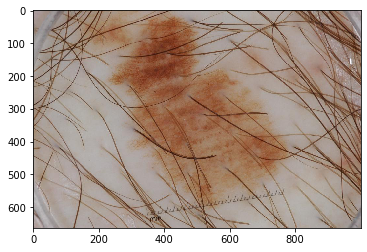

In [11]:
step=50
for data_num in [2,3,4,5]:
    clear_session()
    save_path = tl.get_save_path(data, method, 'unet',patch_size, data_num)
    
    model = BayesianUNet2D((patch_size, patch_size, 3), output_channel).build()
    input_shape = (patch_size,patch_size,3)
    inputs2 = Input(input_shape)
    mc_samples = Lambda(lambda x: K.repeat_elements(x, mc_iteration, axis=0))(inputs2)
    logits = model(mc_samples)
    ret_shape = model.layers[-1].output_shape
    ret_shape = (-1, mc_iteration, *ret_shape[1:])
    probs = Lambda(lambda x: K.reshape(x, ret_shape))(logits)
    outputs = Lambda(lambda x: K.mean(x, axis=1))(probs)
    model2 = Model(inputs=inputs2, outputs=[outputs,outputs])
    
    #save_path = save_path+"stage2/"
    model2.load_weights(save_path+'weights2/weights.h5')
    
    for mode in ["test"]:
        img_path, mask_path = tl.data_path_load(data,mode,data_num)
        
        for i_path in img_path:
            print("************************************")
            print(i_path)
            img = Image.open(i_path)
            width,height=img.size
            plt.imshow(img)
            img = np.array(img) / 255.
            name = os.path.basename(i_path)[:-4]
            Yp=[]
            y=0
            while y < (height - patch_size + 1):
                x = 0
                while x < (width - patch_size + 1):
                    crop_img = img[y:patch_size+y, x:patch_size+x]
                    tmp,_ = model2.predict(crop_img[np.newaxis, :, :, :])
                    tmp = np.reshape(tmp, (patch_size,patch_size,2))
                    Yp.append(tmp)
                    del crop_img,tmp,_
                    gc.collect()
                    x+=step   
                y+=step
            Yp = np.array(Yp)
            
            print("Predict finish")
            vis_img, label_img,e,pro = make_prediction_map(patch_size,
                                                             step,
                                                             width,
                                                             height,
                                                             Yp,
                                                             patch_size,
                                                             reflect,
                                                             data,
                                                             n_class)
            #vis_img = vis_img[:, :, [1, 0]]
            cv2.imwrite(save_path + '%s/' % mode+name + '.png', vis_img)
            probability = np.zeros((height,width,3))
            probability[:,:,0] = pro[:,:,0]
            probability[:,:,1] = pro[:,:,1]
            cv2.imwrite(save_path + '%s_un/probability/' % mode+name + '.png', probability)
            if mode == 'test':
                convert2label(name, save_path)
            e=np.nan_to_num(e)
            tmp =(e-e.min())/(e.max()-e.min())
            e_1=tmp*255
            e_1 = Image.fromarray(e_1)
            e_1 = e_1.convert('RGB')
            e_1.save(save_path + '%s_un/uncertainty/'%mode + name + '.png')
            tmp[tmp>=0.5]=255
            tmp[tmp<0.5]=0
            tmp=Image.fromarray(tmp)
            tmp = tmp.convert('RGB')
            tmp.save(save_path + '%s_un/uncertainty_T_0.5/'%mode + name + '.png')

            del Yp,vis_img, label_img,e,e_1,tmp,pro,probability
            gc.collect()
            print("************************************")
    del model,model2,input_shape,outputs,probs,mc_samples,logits,ret_shape
    gc.collect()

In [ ]:
def pre_data_path_load(path):
    img_path=[]
    if data in ['ips', 'melanoma']:
        for x in os.listdir(path):
            img_path.append(path+x)
        return img_path

In [ ]:
for data_num in [1,2,3,4,5]:
    img_path, mask_path = tl.data_path_load(data,'test',data_num)
    mode="test"
    model_name="unet"
    size=160
    path=("./%s/%s/%s/size_%d/dataset_%d/" %(data, method,model_name,size,data_num))
    #path=("./%s/%s/%s/size_%d/dataset_%d/stage2/" %(data, method,model_name,size,data_num))
    #path=("./%s/%s/%s/size_%d/dataset_%d/stage2/stage3/stage4/" %(data, method,model_name,size,data_num))

    pre_path = pre_data_path_load(path+"%s/"%mode)

    mask_path.sort()
    pre_path.sort()
    for m_path,p_path in zip(mask_path,pre_path):
        print(m_path)
        name = os.path.basename(m_path)[:-4]
        m_mask = cv2.imread(m_path)
        m_mask = cv2.cvtColor(m_mask, cv2.COLOR_BGR2RGB)
        height, width = m_mask.shape[:2]
        imim = m_mask[:,:,0]+m_mask[:,:,1]+m_mask[:,:,2]
        m_mask[:,:,0]=(imim==255)*m_mask[:,:,0]
        m_mask[:,:,1]=(imim==255)*m_mask[:,:,1]
        m_mask[:,:,2]=(imim==255)*m_mask[:,:,2]

        mask = get_ytrue(m_mask, 'ips')
        oor = ~(mask == 0) *1

        p_image = cv2.imread(p_path)
        p_image = cv2.cvtColor(p_image, cv2.COLOR_BGR2RGB)
        p_image[:,:,0] = p_image[:,:,0]* oor 
        p_image[:,:,1] = p_image[:,:,1] * oor 
        p_image[:,:,2] = p_image[:,:,2] * oor
        pre = get_ytrue(p_image, 'ips')
        true=mask-pre
        true[true!=0]=255
        true=true*oor
        true=Image.fromarray(true)
        true = true.convert('RGB')
        true.save(path + 'test_un/correctness/' + name + '.png')